# Наивный Байес и спам
__Суммарное количество баллов: 10__


In [89]:
from sklearn.model_selection import train_test_split
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import spacy
from nltk.stem.snowball import SnowballStemmer
from collections import Counter

In [3]:
import re
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x = []
    y = []
    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [4]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [5]:
X, y = read_dataset("hw6_data/spam")

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [78]:
class NaiveBayes:
    def __init__(self, alpha):
        self.alpha = alpha # Параметр аддитивной регуляризации
    
    def fit(self, X, y):
        self.classes, self.c_y = np.unique(y, return_counts=True)
        self.K = len(self.classes)
        self.total = np.sum(self.c_y)
        self.c_x_y = dict()
        for x, y in zip(X, y):
            if x not in self.c_x_y:
                self.c_x_y[x] = np.zeros(self.K)
            self.c_x_y[x][self.classes.tolist().index(y)] += 1
        
    def predict(self, X):
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X):
        res = []
        for x in X:
            a = self.c_x_y.get(x, np.zeros(self.K))
            res.append(np.log(self.c_y) - np.log(self.total) + np.log(a+1) - np.log(self.c_y + self.K))
        return res

In [88]:
NB = NaiveBayes(0.6)
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print(f'Accuracy {np.mean(y_test == y_pred)}')

Accuracy 0.8888888888888888


### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [108]:
class BoW:
    def __init__(self, X, voc_limit=1000):
        all_words = Counter()
        for x in X:
            all_words += Counter([w.lower() for w in re.findall(r'[A-Za-z]+', x)])
        self.words = [w for w, _ in all_words.most_common(voc_limit)]
        
    def transform(self, X):
        res = []
        for x in X:
            all_words = Counter([w.lower() for w in re.findall(r'[A-Za-z]+', x)])
            vec = [all_words[w] for w in self.words]
            res.append(tuple(vec))
        return res

In [109]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [110]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9018867924528302, 'spam': 1.0},
 {'ham': 1.0, 'spam': 0.35},
 0.9068100358422939)

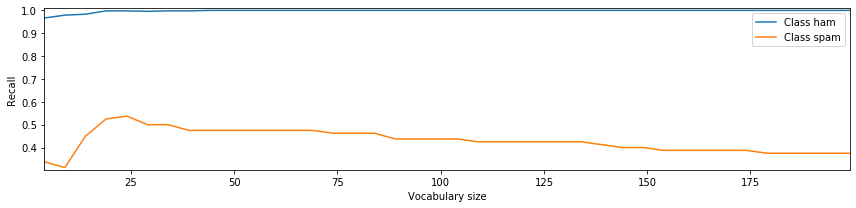

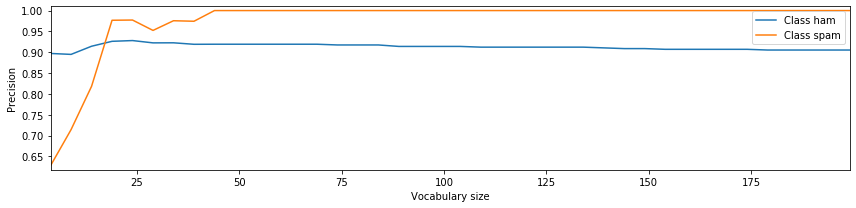

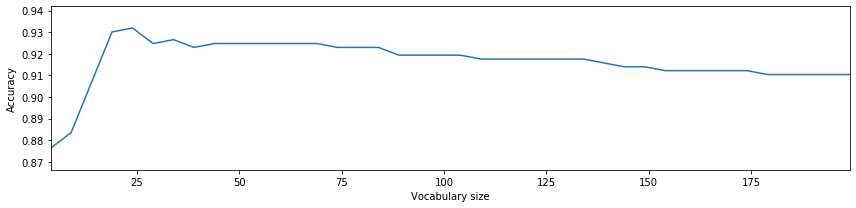

In [111]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [121]:
class BowStem:
    def __init__(self, X, voc_limit=1000):
        self.ss = SnowballStemmer(language='english')
        all_words = Counter()
        for x in X:
            all_words += Counter([self.ss.stem(w) for w in re.findall(r'[A-Za-z]+', x)])
        self.words = [w for w, _ in all_words.most_common(voc_limit)]
        
    def transform(self, X):
        res = []
        for x in X:
            all_words = Counter([self.ss.stem(w) for w in re.findall(r'[A-Za-z]+', x)])
            vec = [all_words[w] for w in self.words]
            res.append(tuple(vec))
        return res

In [122]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [123]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.9018867924528302, 'spam': 1.0},
 {'ham': 1.0, 'spam': 0.35},
 0.9068100358422939)

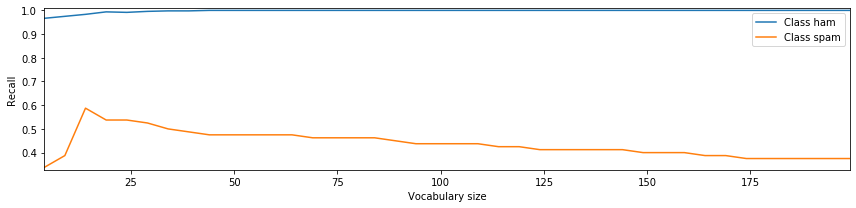

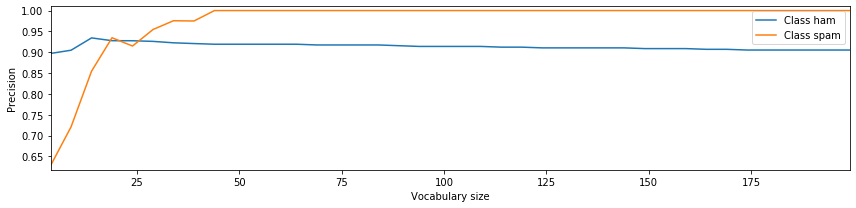

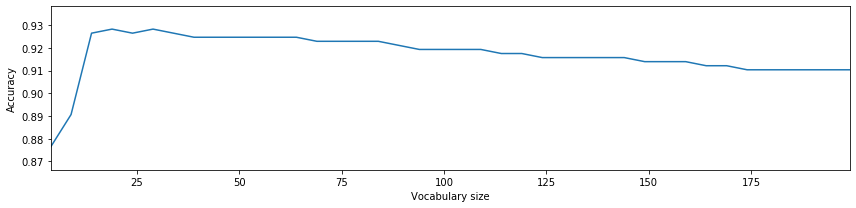

In [124]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)